In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import shutil


- Changes: 
- Increase hidden size from 128 to 512
-num epochs: 50 to 300
-batch size: 16 to 8
input size: 512 to 751
seq length: 1024

In [27]:
filepath = '10 - 300epochNoNormalization'  #cambiar nombre para archivo ej: 8 - 50epochNoNormalization'
script_dir = os.path.dirname('rnn.ipynb')
results_dir = os.path.join(script_dir, filepath + '/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

In [28]:
# Load Data

# Uncomment to save .npy file if not yet saved
#data =  np.loadtxt('./test_series.csv',delimiter=',',dtype=np.float32)
#np.save('test_series', data)
xy = np.load('./coin_data.npy')

X = xy[:,1:] # Indexes inputs
#X = X.astype(np.float32)
#print(type(X[0,0]))

y = xy[:,0] # Indexes Labels
#label_encoder = LabelEncoder()
#y = label_encoder.fit_transform(y)
#print(type(y[0]))

In [29]:
print(f'XY Shape: {xy.shape}')
print(f'xy[0]: {xy[0]}')
print(f'X[0]: {X[0]}')
print(f'y[0]: {y[0]}')

coin_1 = 0
coin_2 = 0
coin_5 = 0
coin_20 = 0
coin_50 = 0
coin_100 = 0
coin_200 = 0
for i in range(xy.shape[0]):
    if xy[i,0] == 0:
        coin_1 += 1
    elif xy[i,0] == 1:
        coin_2 += 1
    elif xy[i,0] == 2:
        coin_5 += 1
    elif xy[i,0] == 3:
        coin_20 += 1
    elif xy[i,0] == 4:
        coin_50 += 1
    elif xy[i,0] == 5:
        coin_100 += 1
    elif xy[i,0] == 6:
        coin_200 += 1
print(f'coin 1: {coin_1}')
print(f'coin 2: {coin_2}')
print(f'coin 5: {coin_5}')
print(f'coin 20: {coin_20}')
print(f'coin 50: {coin_50}')
print(f'coin 100: {coin_100}')
print(f'coin 200: {coin_200}')

XY Shape: (1094, 769025)
xy[0]: [   5. -496. -352. ... 1040.  912.  640.]
X[0]: [-496. -352. -192. ... 1040.  912.  640.]
y[0]: 5.0
coin 1: 151
coin 2: 170
coin 5: 130
coin 20: 137
coin 50: 130
coin 100: 180
coin 200: 196


In [30]:
# Handle Class Imbalance
#class_counts = torch.tensor([count_coin_1, count_coin_2, ..., count_coin_N], dtype=torch.float32)
#class_weights = 1.0 / class_counts  # Inverse frequency
#class_weights /= class_weights.sum()  # Normalize if necessary
#class_weights = class_weights.to(device)
#criterion = nn.CrossEntropyLoss(weight=class_weights)

In [31]:
# Set random seed for reproducibility
torch.manual_seed(7)  # Set the seed for generating random numbers in PyTorch
np.random.seed(7)     # Set the seed for generating random numbers in NumPy

In [32]:
# Define Hyper Parameters

hidden_size = 512
num_classes = 7
num_epochs = 300
batch_size = 8
learning_rate = 0.0001
num_layers = 2

input_size = 751 
sequence_length = 1024  
#input_size = 4 
#sequence_length = 28     


# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Before normalization X_train[0]: [-480. -608. -608. ... -224. -320. -288.]


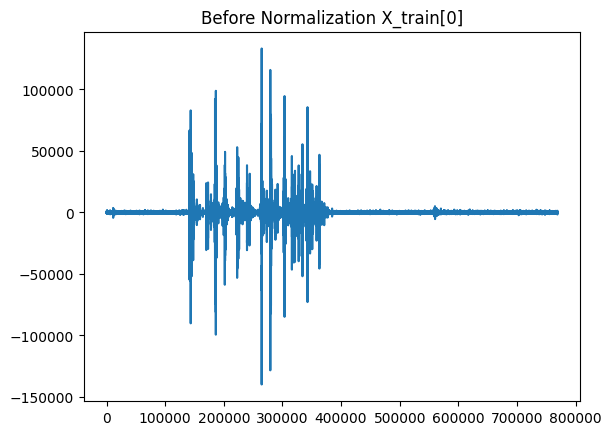

After normalization X_train[0]: [-480. -608. -608. ... -224. -320. -288.]


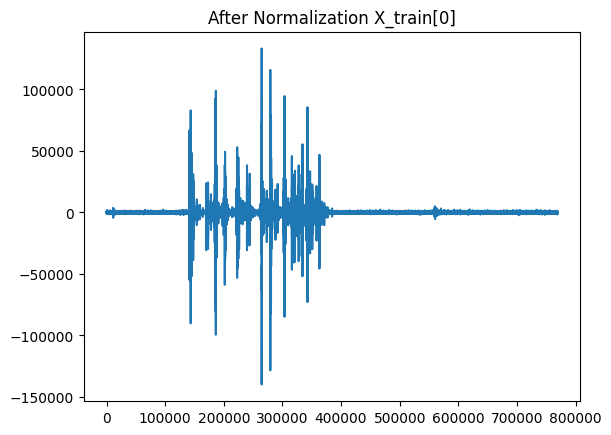

In [33]:
# Random State So it is reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Graph before normalization
print(f'Before normalization X_train[0]: {X_train[0]}')
plt.figure()
plt.title("Before Normalization X_train[0]")
plt.plot(X_train[0])
plt.show()

# Scale and split data
sc = MinMaxScaler(feature_range=(0,1))

# Per sample scaling
#X_train = np.array([sc.fit_transform(sample.reshape(-1, 1)).flatten() for sample in X_train])
#X_test = np.array([sc.fit_transform(sample.reshape(-1, 1)).flatten() for sample in X_test])

# Graph after scaling
#print(f'After normalization X_train[0]: {X_train[0]}')
#plt.figure()
#plt.title("After Per Sample Normalization X_train[0]")
#plt.plot(X_train[0])
#plt.show()

# Global scaling
# sc.fit_transform on X_train and sc.transform on X_test to avoid data leakage
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Graph after scaling
print(f'After normalization X_train[0]: {X_train[0]}')
plt.figure()
plt.title("After Normalization X_train[0]")
plt.plot(X_train[0])
plt.show()

In [34]:
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')
print(f'X_test[0]: {X_test[0]}')
print(f'y_test[0]: {y_test[0]}')

train_coin_1 = 0
train_coin_2 = 0
train_coin_5 = 0
train_coin_20 = 0
train_coin_50 = 0
train_coin_100 = 0
train_coin_200 = 0

for i in range(y_train.shape[0]):
    if y_train[i] == 0:
        train_coin_1 += 1
    elif y_train[i] == 1:
        train_coin_2 += 1
    elif y_train[i] == 2:
        train_coin_5 += 1
    elif y_train[i] == 3:
        train_coin_20 += 1
    elif y_train[i] == 4:
        train_coin_50 += 1
    elif y_train[i] == 5:
        train_coin_100 += 1
    elif y_train[i] == 6:
        train_coin_200 += 1
        
print(f'coin 1: {train_coin_1}')
print(f'coin 2: {train_coin_2}')
print(f'coin 5: {train_coin_5}')
print(f'coin 20: {train_coin_20}')
print(f'coin 50: {train_coin_50}')
print(f'coin 100: {train_coin_100}')
print(f'coin 200: {train_coin_200}')

test_coin_1 = 0
test_coin_2 = 0
test_coin_5 = 0
test_coin_20 = 0
test_coin_50 = 0
test_coin_100 = 0
test_coin_200 = 0
for i in range(y_test.shape[0]):
    if y_test[i] == 0:
        test_coin_1 += 1
    elif y_test[i] == 1:
        test_coin_2 += 1
    elif y_test[i] == 2:
        test_coin_5 += 1
    elif y_test[i] == 3:
        test_coin_20 += 1
    elif y_test[i] == 4:
        test_coin_50 += 1
    elif y_test[i] == 5:
        test_coin_100 += 1
    elif y_test[i] == 6:
        test_coin_200 += 1
print(f'coin 1: {test_coin_1}')
print(f'coin 2: {test_coin_2}')
print(f'coin 5: {test_coin_5}')
print(f'coin 20: {test_coin_20}')
print(f'coin 50: {test_coin_50}')
print(f'coin 100: {test_coin_100}')
print(f'coin 200: {test_coin_200}')

X_train[0]: [-480. -608. -608. ... -224. -320. -288.]
y_train[0]: 6.0
X_test[0]: [ 160.   96. -448. ...  288.   32.  192.]
y_test[0]: 4.0
coin 1: 118
coin 2: 138
coin 5: 104
coin 20: 112
coin 50: 100
coin 100: 146
coin 200: 157
coin 1: 33
coin 2: 32
coin 5: 26
coin 20: 25
coin 50: 30
coin 100: 34
coin 200: 39


In [35]:
# Creates TrainCoinDataSet
class TrainCoinDataSet(Dataset):

    def __init__(self, X_train, y_train):
        # Data Loading
        self.x = torch.from_numpy(X_train.astype(np.float32))
        self.y = torch.from_numpy(y_train).type(torch.LongTensor)
        self.n_samples = y_train.shape[0] # n_samples
        print(self.n_samples)

    def __getitem__(self, index):
        # Allows indexing
        return self.x[index], self.y[index]

    def __len__(self):
        # Allows calling length
        return self.n_samples
    
class TestCoinDataSet(Dataset):

    def __init__(self, X_test, y_test):
        # Data Loading
        self.x = torch.from_numpy(X_test.astype(np.float32))
        self.y = torch.from_numpy(y_test).type(torch.LongTensor)
        self.n_samples = y_test.shape[0] # n_samples
        print(self.n_samples)

    def __getitem__(self, index):
        # Allows indexing
        return self.x[index], self.y[index]

    def __len__(self):
        # Allows calling length
        return self.n_samples

In [36]:
# Creates Dataset
train_data = TrainCoinDataSet(X_train, y_train)
test_data = TestCoinDataSet(X_test, y_test)

875
219


In [37]:
print(train_data[0])
print(test_data[0])

(tensor([-480., -608., -608.,  ..., -224., -320., -288.]), tensor(6))
(tensor([ 160.,   96., -448.,  ...,  288.,   32.,  192.]), tensor(4))


In [38]:
# Defines Train and Test Datasets sizes
#train_size = int(0.8 * len(dataset))  # 80% of the data will be used for training
#test_size = len(dataset) - train_size  # Remaining 20% will be used for test

# Split dataset into training set and test set
#train_data, test_data = random_split(dataset, [train_size, test_size])

# Creates Dataloaders for train and test datasets
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)


In [39]:
print(f'Input shape: {samples.shape} , Labels shape: {labels.shape}')
print(f"Input range after standardization: Min = {samples[0].min()}, Max = {samples[0].max()}")
print(samples[0])
print(labels[0])
print(f'Input dtype: {samples[0,0].dtype}')
print(f'Label dtype: {labels[0].dtype}')
print(f'Labels: {labels}')

Input shape: torch.Size([8, 769024]) , Labels shape: torch.Size([8])
Input range after standardization: Min = -1037400.0, Max = 1023000.0
tensor([-480., -192.,  384.,  ..., -576., -480., -384.])
tensor(5)
Input dtype: torch.float32
Label dtype: torch.int64
Labels: tensor([5, 3, 4, 2, 2, 2, 1, 1])


In [40]:
# Create Model

# Model 
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        #x -> (batch_size, seq, input_size) 
        self.fc = nn.Linear(hidden_size, num_classes)   

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out,_ = self.rnn(x, h0)
        # out: batch_size, seq_lenght, hidden_size
        #out (N,28, 128)
        out = out[:, -1, :]
        #out (N, 128)

        out= self.fc(out)
        return out

       

In [41]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning Rate Scheduler (Reduce by factor of 0.1 every 10 epochs)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Reduces learning rate if loss plateaus
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [42]:
print(model)

RNN(
  (rnn): RNN(751, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=7, bias=True)
)


In [43]:
# Training loop

history = {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc': []}
all_preds = []
all_labels = []

train_loss_steps = []
train_acc_steps = []
running_loss_train_steps = 0.0
n_correct_train_steps = 0
n_samples_train_steps = 0

plot_steps, print_steps = 2,1

running_loss_train = 0.0
n_correct_train = 0
n_samples_train = 0

running_loss_val = 0.0
n_correct_val = 0
n_samples_val = 0

for epoch in range(num_epochs):
    
    model.train()
    running_loss_train = 0.0
    n_correct_train = 0
    n_samples_train = 0

    # Training loop
    for i, (inputs, labels) in enumerate(train_loader):
        
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # For Epoch Graph
        running_loss_train += loss.item()
        _, predictions = torch.max(outputs, 1)
        n_correct_train += (predictions == labels).sum().item()
        n_samples_train += labels.shape[0]

        # For Steps Graph
        running_loss_train_steps += loss.item()
        _, predictions = torch.max(outputs, 1)
        n_correct_train_steps += (predictions == labels).sum().item()
        n_samples_train_steps += labels.shape[0]
        
        if (i+1) % print_steps == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{len(train_loader)}, loss = {loss.item():.4f}')

        if (i+1) % plot_steps == 0:
            train_loss_steps.append(running_loss_train_steps / len(train_loader))
            train_acc_steps.append(100 * n_correct_train_steps / n_samples_train_steps)
            running_loss_train_steps = 0.0
            n_correct_train_steps = 0
            n_samples_train_steps = 0


    history['train_loss'].append(running_loss_train / len(train_loader))
    history['train_acc'].append(100 * n_correct_train / n_samples_train)

    # Test loop

    running_loss_val = 0.0
    n_correct_val = 0
    n_samples_val = 0

    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss
            running_loss_val += loss.item()
            _, predictions = torch.max(outputs, 1)
            n_correct_val += (predictions == labels).sum().item()
            n_samples_val += labels.shape[0]

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if (i+1) % print_steps == 0:
                print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{len(test_loader)}, loss = {loss.item():.4f}')

        history['val_loss'].append(running_loss_val / len(test_loader))
        history['val_acc'].append(100 * n_correct_val / n_samples_val)

epoch 1 / 300, step 1/110, loss = 2.1033
epoch 1 / 300, step 2/110, loss = 1.9481
epoch 1 / 300, step 3/110, loss = 1.9296
epoch 1 / 300, step 4/110, loss = 1.9899
epoch 1 / 300, step 5/110, loss = 2.1543
epoch 1 / 300, step 6/110, loss = 1.9059
epoch 1 / 300, step 7/110, loss = 1.9587
epoch 1 / 300, step 8/110, loss = 1.9383
epoch 1 / 300, step 9/110, loss = 2.0668
epoch 1 / 300, step 10/110, loss = 2.0618
epoch 1 / 300, step 11/110, loss = 1.9547
epoch 1 / 300, step 12/110, loss = 1.8358
epoch 1 / 300, step 13/110, loss = 1.9256
epoch 1 / 300, step 14/110, loss = 1.9341
epoch 1 / 300, step 15/110, loss = 1.8600
epoch 1 / 300, step 16/110, loss = 2.0148
epoch 1 / 300, step 17/110, loss = 1.9980
epoch 1 / 300, step 18/110, loss = 2.0049
epoch 1 / 300, step 19/110, loss = 1.9937
epoch 1 / 300, step 20/110, loss = 1.9199
epoch 1 / 300, step 21/110, loss = 2.1392
epoch 1 / 300, step 22/110, loss = 1.8642
epoch 1 / 300, step 23/110, loss = 2.0796
epoch 1 / 300, step 24/110, loss = 2.0566
e

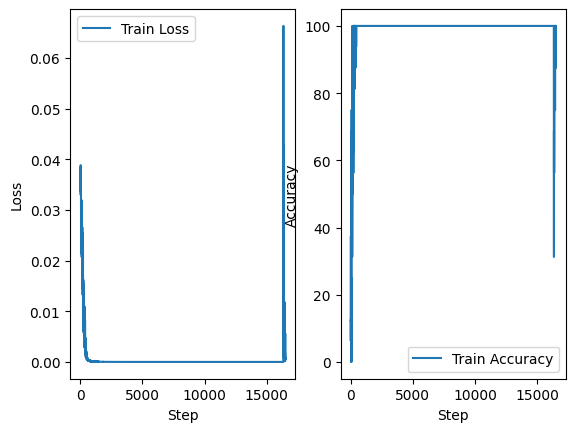

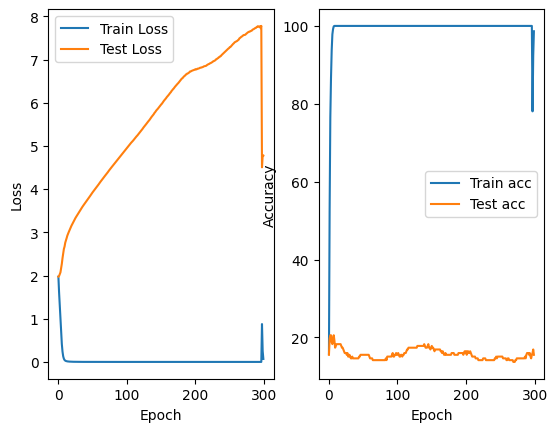

In [44]:
fig , ax = plt.subplots(1,2,sharex=True)

ax [0].plot(train_loss_steps, label='Train Loss')
ax [0].set_xlabel('Step')
ax [0].set_ylabel('Loss')
ax [0].legend()

ax [1].plot(train_acc_steps, label='Train Accuracy')
ax [1].set_xlabel('Step')
ax [1].set_ylabel('Accuracy')
ax [1].legend()

plt.savefig(results_dir + '/StepGraph.png')
plt.show() 

fig , ax = plt.subplots(1,2,sharex=True)

ax [0].plot(history['train_loss'], label='Train Loss')
ax [0].plot(history['val_loss'], label='Test Loss')
ax [0].set_xlabel('Epoch')
ax [0].set_ylabel('Loss')
ax [0].legend()

ax [1].plot(history['train_acc'], label='Train acc')
ax [1].plot(history['val_acc'], label='Test acc')
ax [1].set_xlabel('Epoch')
ax [1].set_ylabel('Accuracy')
ax [1].legend()

plt.savefig(results_dir + '/EpochGraph.png')
plt.show() 

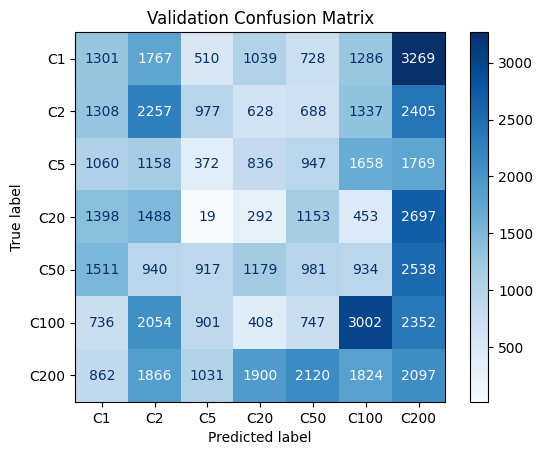

In [45]:
"""
Plot a confusion matrix using true and predicted labels.

Parameters:
    all_labels: List of true labels.
    all_preds: List of predicted labels.
    class_names: List of class names for labeling the confusion matrix.
"""
class_names = ['C1','C2','C5','C20','C50','C100','C200']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
disp.figure_.savefig(results_dir + 'Confusion_Matrix.png')
plt.show()


In [46]:
print(f"after {num_epochs} epochs the trainning accuracy is {history["train_acc"][-1]} and the test accuaracy is {history["val_acc"][-1]} ")

test_accuracy_max= max(history["val_acc"])
train_accuracy_max=max(history["train_acc"])

idx_max_test_accuracy=history["val_acc"].index(test_accuracy_max)

idx_max_train_accuracy=history["train_acc"].index(train_accuracy_max)

print(f" the maximum accuracy of the test was {max(history["val_acc"])} at the epoch {idx_max_test_accuracy}")

print(f" the maximum accuracy of the train was {max(history["train_acc"])} at the epoch {idx_max_train_accuracy}")

print(f"the accuracy of the training at the best validation accuracy {max(history["val_acc"])} is {history["train_acc"][idx_max_test_accuracy]}  ")

after 300 epochs the trainning accuracy is 98.62857142857143 and the test accuaracy is 15.525114155251142 
 the maximum accuracy of the test was 20.54794520547945 at the epoch 2
 the maximum accuracy of the train was 100.0 at the epoch 8
the accuracy of the training at the best validation accuracy 20.54794520547945 is 76.45714285714286  


In [47]:
# Copy the 
shutil.copyfile('./rnn.ipynb', './' + results_dir + 'rnn.ipynb')

'./10 - 300epochNoNormalization/rnn.ipynb'